In [ ]:
import pandas as pd
import sqlite3
import joblib
import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    mean_squared_error, mean_absolute_error
)

def train_burglary_classifier_with_6plus_regression(db_path='crime_data.db', model_path='models/'):
    os.makedirs(model_path, exist_ok=True)

    # Load data
    conn = sqlite3.connect(db_path)
    crime_df = pd.read_sql_query(""" 
        SELECT crimeID, Month, Longitude, Latitude, Outcome, LSOA_code, WD24CD, Type
        FROM crime
        WHERE substr(Month, 1, 7) BETWEEN '2022-01' AND '2025-02';
    """, conn)
    prices_df = pd.read_sql_query("SELECT WD23CD, Average_Price FROM ward_average_prices;", conn)
    conn.close()

    crime_df['Month'] = pd.to_datetime(crime_df['Month'], format='%Y-%m')

    all_combinations = []
    for target_month in pd.date_range('2024-01', '2025-02', freq='MS'):
        month1 = target_month - pd.DateOffset(years=2)
        month2 = target_month - pd.DateOffset(years=1)
        retrospective_months = [target_month - pd.DateOffset(months=i) for i in [1, 2, 3]]

        month1_data = crime_df[crime_df['Month'] == month1]
        month2_data = crime_df[crime_df['Month'] == month2]
        retrospective_data = crime_df[crime_df['Month'].isin(retrospective_months)]

        def agg(df, name):
            return df.groupby('LSOA_code').size().reset_index(name=name)

        total1 = agg(month1_data, 'crimes_m1')
        total2 = agg(month2_data, 'crimes_m2')
        burg1 = agg(month1_data[month1_data['Type'] == 'Burglary'], 'burg_m1')
        burg2 = agg(month2_data[month2_data['Type'] == 'Burglary'], 'burg_m2')

        total_3m = retrospective_data.groupby('LSOA_code').size().reset_index(name='crime_3m_sum')
        burg_3m = retrospective_data[retrospective_data['Type'] == 'Burglary'] \
            .groupby('LSOA_code').size().reset_index(name='burglary_3m_sum')

        total_3m['crime_3m_avg'] = total_3m['crime_3m_sum'] / 3
        burg_3m['burglary_3m_avg'] = burg_3m['burglary_3m_sum'] / 3

        features_df = total1.merge(total2, on='LSOA_code', how='outer') \
                            .merge(burg1, on='LSOA_code', how='outer') \
                            .merge(burg2, on='LSOA_code', how='outer') \
                            .merge(total_3m[['LSOA_code', 'crime_3m_avg']], on='LSOA_code', how='outer') \
                            .merge(burg_3m[['LSOA_code', 'burglary_3m_avg']], on='LSOA_code', how='outer') \
                            .fillna(0)

        features_df['trend'] = features_df['crimes_m2'] - features_df['crimes_m1']
        features_df['ma'] = features_df[['crimes_m1', 'crimes_m2']].mean(axis=1)

        # Price mapping
        lsoa_to_ward = month1_data[['LSOA_code', 'WD24CD']].drop_duplicates()
        lsoa_price_map = lsoa_to_ward.merge(prices_df, left_on='WD24CD', right_on='WD23CD', how='left')
        features_df = features_df.merge(lsoa_price_map[['LSOA_code', 'Average_Price']], on='LSOA_code', how='left')
        features_df = features_df.dropna(subset=['Average_Price'])

        # Target
        target_data = crime_df[(crime_df['Month'] == target_month) & (crime_df['Type'] == 'Burglary')]
        target_counts = target_data.groupby('LSOA_code').size().reset_index(name='target')
        features_df = features_df.merge(target_counts, on='LSOA_code', how='left').fillna({'target': 0})

        all_combinations.append(features_df)

    combined_data = pd.concat(all_combinations, ignore_index=True)

    # Define target class: 0-5, and 6+ as 6
    combined_data['target_class'] = combined_data['target'].apply(lambda x: x if x < 6 else 6)

    feature_cols = [
        'crimes_m1', 'crimes_m2', 'burg_m1', 'burg_m2',
        'trend', 'ma', 'crime_3m_avg', 'burglary_3m_avg',
        'Average_Price'
    ]
    X = combined_data[feature_cols]
    y_class = combined_data['target_class']
    y_reg = combined_data['target']

    # Stratified split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in sss.split(X, y_class):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train_class, y_test_class = y_class.iloc[train_idx], y_class.iloc[test_idx]
        y_train_reg, y_test_reg = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train_class)
    y_pred_class = clf.predict(X_test)

    print("\n--- Classification Report (0–6) ---")
    print(classification_report(y_test_class, y_pred_class))
    print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))

    # Train regressor on 6+ class
    reg_train_idx = y_train_class[y_train_class == 6].index
    reg = RandomForestRegressor(n_estimators=200, random_state=42)
    reg.fit(X_train.loc[reg_train_idx], y_train_reg.loc[reg_train_idx])

    # Apply regressor to test instances where classifier predicted class 6
    reg_test_idx = y_test_class.index[y_pred_class == 6]
    reg_y_pred = reg.predict(X_test.loc[reg_test_idx])
    reg_y_pred_rounded = np.round(reg_y_pred).astype(int)

    # Combine final predictions
    final_pred = pd.Series(y_pred_class, index=y_test_class.index)
    final_pred.loc[reg_test_idx] = reg_y_pred_rounded
    final_true = y_test_reg

    # Final evaluation
    exact_match_acc = (final_pred == final_true).mean()
    print(f"\n--- Final Combined Accuracy (classification + regression) ---")
    print(f"Exact match accuracy: {exact_match_acc * 100:.2f}%")

    if len(reg_y_pred_rounded) > 0:
        print("\n--- Regression Performance on 6+ ---")
        print("RMSE:", np.sqrt(mean_squared_error(y_test_reg.loc[reg_test_idx], reg_y_pred_rounded)))
        print("MAE:", mean_absolute_error(y_test_reg.loc[reg_test_idx], reg_y_pred_rounded))

    # Save models and features
    joblib.dump(clf, os.path.join(model_path, 'hybrid_classifier.pkl'))
    joblib.dump(reg, os.path.join(model_path, 'six_plus_regressor.pkl'))
    joblib.dump(feature_cols, os.path.join(model_path, 'feature_columns.pkl'))
    print("\nModels and features saved to:", model_path)

train_burglary_classifier_with_6plus_regression()



--- Classification Report (0–6) ---
              precision    recall  f1-score   support

         0.0       0.65      0.90      0.75      7334
         1.0       0.54      0.35      0.42      3709
         2.0       0.62      0.29      0.40      1613
         3.0       0.74      0.33      0.46       724
         4.0       0.84      0.37      0.52       303
         5.0       0.83      0.45      0.59       143
         6.0       0.78      0.59      0.68       175

    accuracy                           0.64     14001
   macro avg       0.71      0.47      0.55     14001
weighted avg       0.63      0.64      0.60     14001

Confusion Matrix:
 [[6605  614   89   18    6    2    0]
 [2279 1290  107   22    3    3    5]
 [ 849  261  473   15    4    3    8]
 [ 292  132   42  242    5    3    8]
 [  96   53   23   11  113    1    6]
 [  41   19    8    8    0   65    2]
 [  16   22   17   11    4    1  104]]

--- Final Combined Accuracy (classification + regression) ---
Exact match accur

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Load your saved classifier
import joblib
clf = joblib.load('models/hybrid_classifier.pkl')  # Adjust path if needed

# Choose a tree (e.g., the first one)
tree = clf.estimators_[0]

# Plot the tree (can be slow if tree is large)
plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names=joblib.load('models/feature_columns.pkl'),
          class_names=[str(i) for i in range(7)],  # 0–6
          filled=True,
          max_depth=3,  # Adjust depth to avoid clutter
          fontsize=10)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'models/hybrid_classifier.pkl'

In [14]:
import pandas as pd
import sqlite3
import joblib
import os
import numpy as np
from datetime import datetime

def predict_burglary_for_next_year(db_path='crime_data.db', model_path='models/'):
    reg = joblib.load(os.path.join(model_path, 'regressor.pkl'))
    feature_cols = joblib.load(os.path.join(model_path, 'feature_columns.pkl'))

    conn = sqlite3.connect(db_path)
    crime_df = pd.read_sql_query("""
        SELECT crimeID, Month, Longitude, Latitude, Outcome, WD24CD, Type
        FROM crime
        WHERE substr(Month, 1, 7) BETWEEN '2022-01' AND '2025-02';
    """, conn)
    prices_df = pd.read_sql_query("SELECT WD23CD, Average_Price FROM ward_average_prices;", conn)
    conn.close()

    crime_df['Month'] = pd.to_datetime(crime_df['Month'], format='%Y-%m')
    crime_df['lat_bin'] = crime_df['Latitude']
    crime_df['lon_bin'] = crime_df['Longitude']

    predictions = []

    for target_month in pd.date_range('2025-03', '2026-02', freq='MS'):
        month1 = target_month - pd.DateOffset(years=2)
        month2 = target_month - pd.DateOffset(years=1)

        month1_str = month1.strftime('%Y%m')
        month2_str = month2.strftime('%Y%m')

        month1_data = crime_df[crime_df['Month'] == month1]
        month2_data = crime_df[crime_df['Month'] == month2]

        month1_crimes = month1_data.groupby(['lat_bin', 'lon_bin']).size().reset_index(name=f'total_crimes_{month1_str}')
        month2_crimes = month2_data.groupby(['lat_bin', 'lon_bin']).size().reset_index(name=f'total_crimes_{month2_str}')
        month1_burg = month1_data[month1_data['Type'] == 'Burglary'].groupby(['lat_bin', 'lon_bin']).size().reset_index(name=f'burglary_{month1_str}')
        month2_burg = month2_data[month2_data['Type'] == 'Burglary'].groupby(['lat_bin', 'lon_bin']).size().reset_index(name=f'burglary_{month2_str}')

        features_df = month1_crimes.merge(month2_crimes, on=['lat_bin', 'lon_bin'], how='outer') \
                                   .merge(month1_burg, on=['lat_bin', 'lon_bin'], how='outer') \
                                   .merge(month2_burg, on=['lat_bin', 'lon_bin'], how='outer')
        features_df = features_df.fillna(0)

        features_df[f'crime_trend_{month1_str}_{month2_str}'] = (
            features_df[f'total_crimes_{month2_str}'] - features_df[f'total_crimes_{month1_str}']
        )
        features_df[f'crime_ma_{month1_str}_{month2_str}'] = features_df[
            [f'total_crimes_{month1_str}', f'total_crimes_{month2_str}']
        ].mean(axis=1)

        price_map = month1_data[['lat_bin', 'lon_bin', 'WD24CD']].drop_duplicates()
        price_map = price_map.merge(prices_df, left_on='WD24CD', right_on='WD23CD', how='left')
        features_df = features_df.merge(price_map[['lat_bin', 'lon_bin', 'Average_Price']], on=['lat_bin', 'lon_bin'], how='left')
        features_df = features_df.dropna()

        features_df['Latitude'] = features_df['lat_bin']
        features_df['Longitude'] = features_df['lon_bin']

        # Ensure all required feature columns are present
        missing_cols = set(feature_cols) - set(features_df.columns)
        for col in missing_cols:
            features_df[col] = 0
        X = features_df[feature_cols]

        preds = reg.predict(X)
        preds_rounded = np.round(preds).astype(int)

        for lat, lon, pred in zip(features_df['Latitude'], features_df['Longitude'], preds_rounded):
            predictions.append({
                'Latitude': lat,
                'Longitude': lon,
                'Month': target_month.strftime('%Y-%m'),
                'Burglary_prediction': pred
            })

        print(f"Predictions for {target_month.strftime('%B %Y')} done.")

    predictions_df = pd.DataFrame(predictions)

    # Save to CSV
    predictions_df.to_csv(os.path.join(model_path, 'burglary_predictions_march_2025_feb_2026.csv'), index=False)
    print("Predictions saved to 'burglary_predictions_march_2025_feb_2026.csv'")

    # Print number of distinct rounded burglary counts
    unique_counts = predictions_df['Burglary_prediction'].nunique()
    print(f"Number of distinct rounded burglary predictions: {unique_counts}")

predict_burglary_for_next_year()


Predictions for March 2025 done.
Predictions for April 2025 done.
Predictions for May 2025 done.
Predictions for June 2025 done.
Predictions for July 2025 done.
Predictions for August 2025 done.
Predictions for September 2025 done.
Predictions for October 2025 done.
Predictions for November 2025 done.
Predictions for December 2025 done.
Predictions for January 2026 done.
Predictions for February 2026 done.
Predictions saved to 'burglary_predictions_march_2025_feb_2026.csv'
Number of distinct rounded burglary predictions: 1


In [ ]:
predict_burglary_for_month(target_month = )

total_crimes_2024: 0.2507
crime_trend: 0.2329
Average_Price: 0.2585
crime_ma: 0.2578


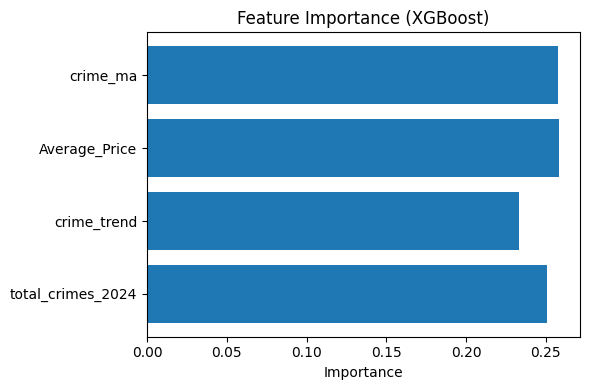

In [13]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = reg.feature_importances_
feature_names = X.columns

# Print values
for name, importance in zip(feature_names, feature_importances):
    print(f"{name}: {importance:.4f}")

# Optional: Plot
plt.figure(figsize=(6, 4))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_class, class_preds).ravel()

print("Confusion Matrix Results:")
print(f"  True Positives (TP):  {tp}")
print(f"  False Positives (FP): {fp}")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Negatives (FN): {fn}")


Confusion Matrix Results:
  True Positives (TP):  3709
  False Positives (FP): 2
  True Negatives (TN):  62794
  False Negatives (FN): 75


In [16]:
print(len(result))

39855


In [20]:
# Exact match count
exact_matches = (result['predicted'] == result['target_burglaries']).sum()
total_samples = len(result)

# Percentage of exact matches
exact_match_percentage = (exact_matches / total_samples) * 100

print("\n--- Regression Evaluation ---")
print(f"  Exact Matches: {exact_matches} out of {total_samples}")
print(f"  Exact Match Percentage: {exact_match_percentage:.2f}%")



--- Regression Evaluation ---
  Exact Matches: 38142 out of 39855
  Exact Match Percentage: 95.70%
